In [1]:
import os

from math import ceil
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import optimize
import emcee
from corner import corner
from scipy import stats

import constants as const

plt.style.use('science')

In [2]:
lo = np.loadtxt('spectra_local_lo_a0_fix_hpp_n_14.txt')
nlo = np.loadtxt('spectra_local_nlo_a0_B6_fix_coord_hp_n_14_coord_ir_corrected.txt')
mm = np.loadtxt('spectra_Mott_Massey.txt')

In [3]:
gamma_mm_6 = np.sqrt(2*const.MU*-mm)[-1]

In [4]:
def convergence(lamb, c1, c2):
    return c1 * (1 + c2*(1/lamb))


def convergence_improved(lamb, c1, c2, q):
    return c1 * (1 + c2*(q/lamb))


def convergence2(lamb, c1, c2):
    return c1 * (1 + c2*(1/lamb)**2)


def convergence12(lamb, c1, c2, c3):
    return c1 * (1 + c2/lamb + c3/lamb**2)


def convergence12_improved(lamb, c1, c2, c3, q):
    return c1 * (1 + c2*(q/lamb) + c3*(q/lamb)**4)

$\Lambda \equiv 1/R$

## LO

10.70  0.0306  [-0.29767352 -0.12552025]
7.86  0.0306  [-0.14939243 -0.11718185]
5.47  0.0306  [-0.06844564 -0.10462745]
3.52  0.0306  [-0.02724983 -0.08831455]
2.00  0.0306  [-0.00859394 -0.06930987]
0.91  0.0306  [-0.00174817 -0.04973367]
0.24  0.0306  [-0.00011936 -0.0446195 ]


Text(0, 0.5, '$E$')

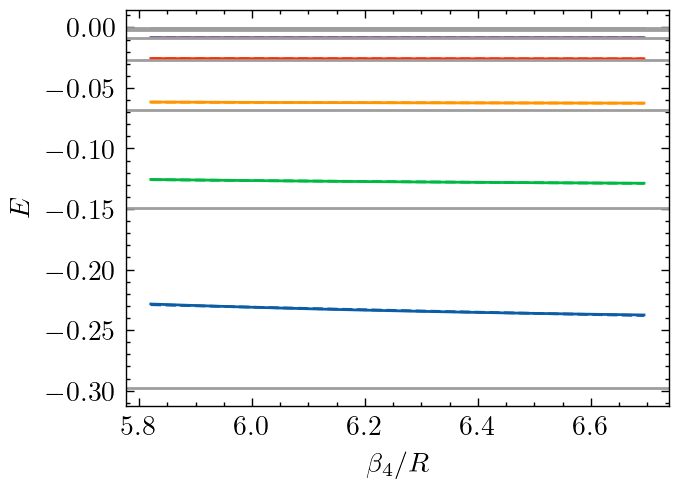

In [8]:
R_lo = lo[:, 0]
x_lo = np.pi / R_lo
energies_lo = lo[:, 1:].T

ii = np.intersect1d(
    np.where(const.BETA4/np.pi*x_lo > 60)[0],
    np.where(const.BETA4/np.pi*x_lo < 70)[0]
)

fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

lo_asymp = []

for (i, row) in enumerate(energies_lo):
    gamma = np.sqrt(2*const.MU*-row[-1])
    pars, cov = optimize.curve_fit(lambda x, c1, c2: convergence_improved(x, c1, c2, gamma), x_lo[ii], row[ii])
    print(f'{gamma:.2f}  {1/const.BETA4:.4f}  {pars}')
    lo_asymp.append(pars[0])
    
    ax.plot(x_lo[ii], row[ii], color=f'C{i}')
    ax.plot(x_lo[ii], convergence_improved(x_lo[ii], *pars, gamma), linestyle='--', color=f'C{i}')
    ax.axhline(pars[0], color='C6')

ax.set_xlabel(r'$\beta_4/R$')
ax.set_ylabel(r'$E$')

## NLO

In [9]:
lower_bounds = [
    -np.inf,
    -50,
    -100
]

upper_bounds = [
    np.inf,
    50,
    100
]

bounds = optimize.Bounds(lower_bounds, upper_bounds)

In [10]:
d = stats.uniform(-1, 1)

In [45]:
ndim = 3

def construct_priors(e_max_Lambda):
    return [
        stats.norm(e_max_Lambda, 0.1*np.abs(e_max_Lambda)),
        stats.norm(0, 0.2),
        stats.norm(0, 1)
    ]


class Model:
    def __init__(self, Lambdas, energies, de_factor=0.01, n_walkers=4*ndim):
        self.Lambdas = Lambdas.copy()
        self.Rs = np.pi / self.Lambdas
        self.energies = energies.copy()
        self.de = de_factor * np.abs(self.energies - self.energies[-1]) + np.abs(1e-5*self.energies[-1])
        if np.any(self.energies > 0):
            self.energies *= -1
        self.gamma = np.sqrt(2*const.MU*np.abs(energies[-1]))
        
        self.priors = construct_priors(self.energies[-1])
        
        self.nw = n_walkers
        self.theta0 = np.array([[d.rvs() for d in self.priors] for _ in range(self.nw)])
        self.sampler = emcee.EnsembleSampler(self.nw, ndim, self.ln_posterior,
            moves=[(emcee.moves.DEMove(), 0.8), (emcee.moves.DESnookerMove(), 0.2)])
    
    
    def ln_prior(self, theta):
        return np.sum([d.logpdf(t) for (t, d) in zip(theta, self.priors)])
    
    
    def ln_likelihood(self, theta):
        mu = convergence12_improved(self.Lambdas, *theta, np.sqrt(2*const.MU*np.abs(theta[0])))
        return -np.sum(((self.energies - mu)/self.de)**2)

    
    def ln_posterior(self, theta):
        return self.ln_prior(theta) + self.ln_likelihood(theta)
    
    
    def run(self, ns):
        return self.sampler.run_mcmc(self.theta0, ns, progress=True, thin_by=10)
    
    
    def cont(self, ns):
        x0 = self.sampler.get_last_sample().coords
        return self.sampler.run_mcmc(x0, ns, progress=True, thin_by=10)
                                     

In [46]:
nlo.shape

(79, 8)

In [99]:
R_nlo = nlo[:, 0]
x_nlo = np.pi / R_nlo
energies_nlo = -nlo[:, 1:-1].T

ii = np.intersect1d(
    np.where(const.BETA4/np.pi*x_nlo > 55)[0],
    np.where(const.BETA4/np.pi*x_nlo < 70)[0]
)

index = 5

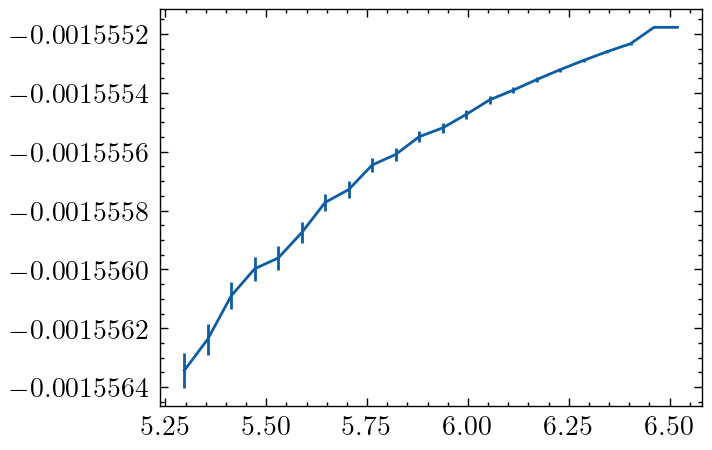

In [100]:
factor = 5e-2

fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.errorbar(x_nlo[ii], energies_nlo[index, ii],
            yerr=factor*np.abs(energies_nlo[index, ii] - energies_nlo[index, ii[-1]]));

In [101]:
m = Model(x_nlo[ii], energies_nlo[index, ii], de_factor=factor)

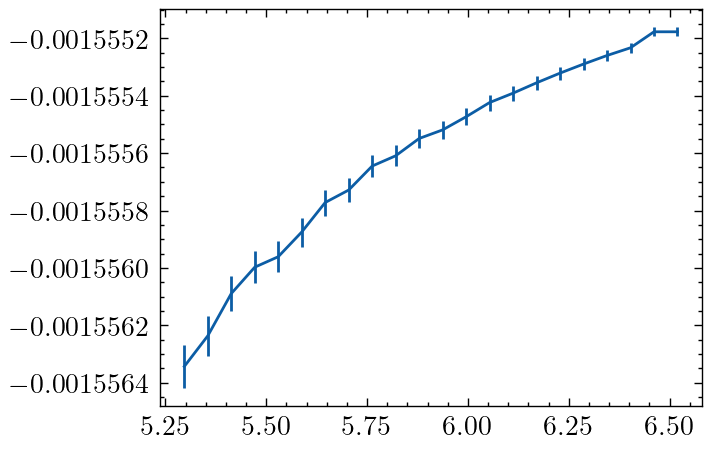

In [102]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.errorbar(m.Lambdas, m.energies, yerr=m.de);

In [104]:
state = m.sampler.run_mcmc(m.theta0, 2000, thin_by=20, progress=True)

100%|████████████████████████████████████████████████████████| 40000/40000 [01:05<00:00, 609.36it/s]


In [105]:
# state = m.cont(2000)

In [110]:
nb = 1700
lnp = m.sampler.get_log_prob()
ii = np.where(np.min(lnp[nb:], axis=0) > -np.inf)[0]

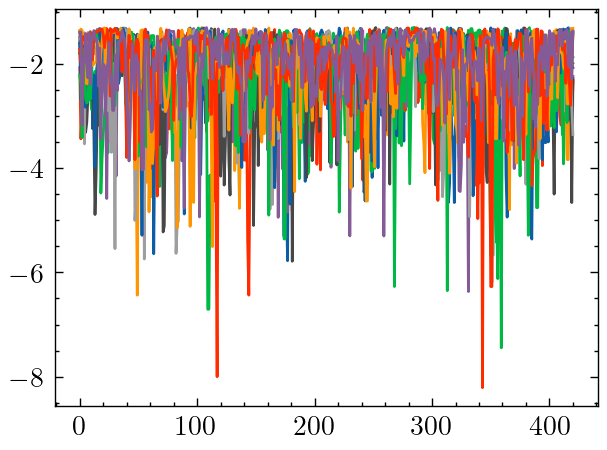

In [111]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(lnp[nb:, ii]);

In [112]:
tau = ceil(np.max(emcee.autocorr.integrated_time(m.sampler.get_chain(discard=nb)[:, ii, :])))

In [113]:
chain = m.sampler.get_chain(discard=nb, thin=70)[:, ii, :]

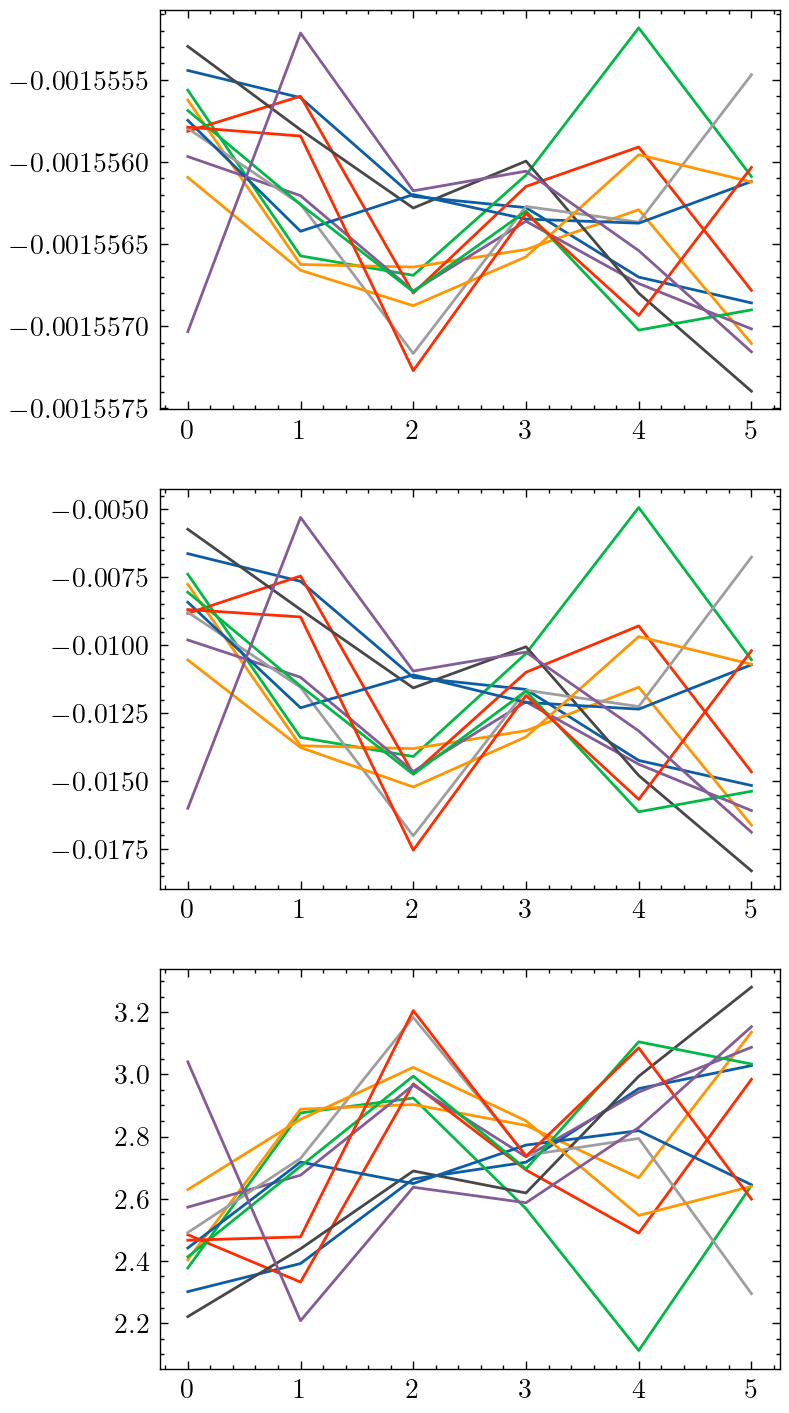

In [114]:
fig, ax = plt.subplots(ndim, figsize=(4, 9), dpi=200)
fig.patch.set_facecolor('white')

for i in range(ndim):
    ax[i].plot(chain[:, :, i])

In [115]:
flat_lnp = lnp[nb:].flatten()
flat_chain = m.sampler.get_chain(discard=nb, flat=True)
theta_star = flat_chain[np.argmax(flat_lnp)]

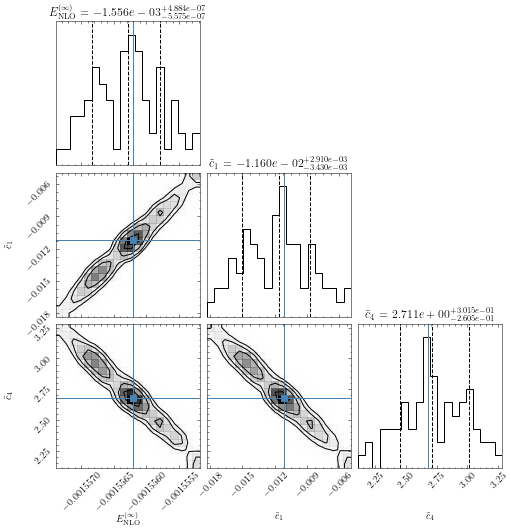

In [116]:
fig = corner(chain.reshape(-1, 3), truths=theta_star, quantiles=[0.16, 0.5, 0.84], show_titles=True,
             labels=[r'$E_{\rm NLO}^{(\infty)}$', r'$\tilde{c}_1$', r'$\tilde{c}_4$'],
             smooth=True, title_fmt='.3e')

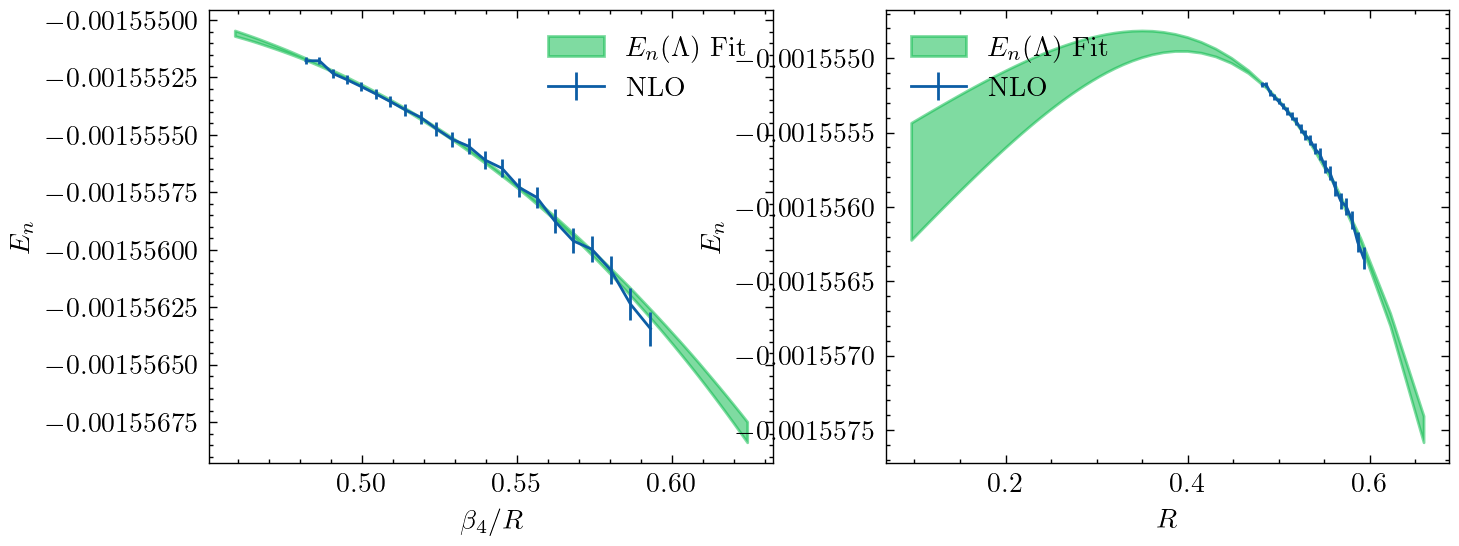

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=200)
fig.patch.set_facecolor('white')

wide_Lambdas = np.linspace(0.95*m.Lambdas[0], 1.05*m.Lambdas[-1], 100)
wide_Rs = np.pi / wide_Lambdas

mus = np.array(
    [convergence12_improved(wide_Lambdas, *theta, m.gamma) for theta in chain.reshape(-1, ndim)]
)
low, med, high = np.quantile(mus, [0.16, 0.5, 0.84], axis=0)

ax[0].fill_between(wide_Rs, low, high, color='C1', alpha=0.5, label=r'$E_n(\Lambda)$ Fit')
ax[0].errorbar(m.Rs, m.energies, yerr=m.de, label='NLO')

ax[0].legend()
ax[0].set_xlabel(r'$\beta_4/R$')
ax[0].set_ylabel(r'$E_n$')

wide_Lambdas = np.linspace(0.9*m.Lambdas[0], 5*m.Lambdas[-1], 100)
wide_Rs = np.pi / wide_Lambdas

mus = np.array(
    [convergence12_improved(wide_Lambdas, *theta, m.gamma) for theta in chain.reshape(-1, ndim)]
)
low, med, high = np.quantile(mus, [0.16, 0.5, 0.84], axis=0)

ax[1].fill_between(wide_Rs, low, high, color='C1', alpha=0.5, label=r'$E_n(\Lambda)$ Fit')
ax[1].errorbar(m.Rs, m.energies, yerr=m.de, label='NLO')

ax[1].legend()
ax[1].set_xlabel(r'$R$')
ax[1].set_ylabel(r'$E_n$');